# INTRODUCTION

**Project Title:** "Predicting Completion of Clinical Studies with Explainability"

**Author:** Thushara R Shenoi

**Date of Submission:** 25 Jan, 2024

**Abstract:**

Clinical trials are vital in advancing medical research by determining the efficacy and safety of new treatments. However, a significant number of trials fail to progress due to factors such as patient ineligibility, recruitment challenges, and unforeseen complications. These failures result in substantial financial losses, delays in life-saving treatments, and inefficiencies in resource allocation. To address this, I propose a machine learning-based solution that predicts the likelihood of a clinical trial being completed based on historical trial data. By leveraging structured and unstructured features, the model provides actionable insights into trial outcomes. Furthermore, I enhanced the solution with model explainability using SHAP and LIME, offering domain experts transparency into key factors influencing predictions. As an extended solution, I would also like to propose an AI-powered agent that allows scientists to interact with trial data through natural language queries. This agent provides detailed explanations for trial outcomes, suggests modifications to improve success rates, and offers insights from similar case studies, ultimately empowering researchers to design more effective clinical trials.


**Business Context:**

Clinical trials are the cornerstone of pharmaceutical research, enabling the development of treatments that improve patient outcomes and advance medical knowledge. However, these trials are complex, resource-intensive, and fraught with challenges. A significant proportion of clinical trials fail to reach completion, resulting in wasted financial investments, lost time, and unutilized laboratory resources. These failures can stem from various factors such as insufficient patient recruitment, overly stringent eligibility criteria, or unforeseen complications during the trial phases.

The repercussions of failed trials are far-reaching. Pharmaceutical companies face immense financial losses, with billions of dollars spent on research that does not yield results. Moreover, delays caused by trial failures hinder the timely delivery of life-saving treatments to patients, further straining healthcare systems. These inefficiencies also dampen investor confidence and slow down innovation in the pharmaceutical sector.

Given the high stakes and substantial costs involved, there is a pressing need for a data-driven approach to predict the likelihood of trial success. By leveraging historical clinical trial data, pharmaceutical companies can identify potential risks early, optimize resource allocation, and streamline the trial design process. Such predictive insights not only improve the probability of trial completion but also enhance overall operational efficiency and decision-making in the pharmaceutical industry.

My proposed solution aims to address this pressing issue by utilizing machine learning models to predict trial outcomes, providing explainability to align predictions with domain understanding, and enabling researchers to design more effective and efficient clinical trials.

**Dataset Overview:**

Information about the dataset:

1.  **Source:** clinicaltrials.gov
2.  **Size:** Subset of 450,000 trials

The following is the procedure to build the model which could tell us whether the trial proposed is going to succeed or not.







# **Mounting Google Drive in Google Colab**

**Objective:**

Connect Google Colab to your Google Drive to access datasets stored in the Drive. This step ensures that files can easily be read and written into directly from/to the Drive while working in Colab.

In [1]:
# mount google drive and give colaboratory the access to the datasets.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Necessary Libraries

**Objective:**

Import all the libraries required for data processing, visualization, building and evaluating machine learning models.

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [3]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
import optuna

# Loading the Datasets

**Objective:**

 Load the datasets from the Google Drive into the Colab environment for further analysis and processing.

In [4]:
# Load datasets
eligibilities = pd.read_csv('/content/drive/MyDrive/Novartis/eligibilities.csv')
drop_withdrawals = pd.read_csv('/content/drive/MyDrive/Novartis/drop_withdrawals.csv')
facilities = pd.read_csv('/content/drive/MyDrive/Novartis/facilities.csv')
reported_events = pd.read_csv('/content/drive/MyDrive/Novartis/reported_events.csv')
usecase= pd.read_csv('/content/drive/MyDrive/Novartis/usecase_3_.csv')

# DATA PREPROCESSING

## Preprocessing, Missing Data Handling, and Feature Engineering

**Objective:**
The goal of this step is to prepare the data for machine learning modeling by handling missing values, creating new features, and ensuring the data is in a clean and usable format.

In [5]:
## Step 1: Renaming Columns and Dropping Duplicates

usecase = usecase.rename(columns={'NCT Number': 'nct_id'})
facilities = facilities.drop_duplicates(subset=['nct_id'])
reported_events = reported_events.drop_duplicates(subset=['nct_id'])

## Step 2: Merging Datasets

merged_data = usecase.merge(eligibilities, on='nct_id', how='left') \
                     .merge(drop_withdrawals, on='nct_id', how='left') \
                     .merge(facilities, on='nct_id', how='left', suffixes=('_facilities', '_drop_withdrawals')) \
                     .merge(reported_events, on='nct_id', how='left', suffixes=('_reported_events', '_facilities'))

## Step 3: Handling Missing Values

# Drop rows with more than 50% missing data
merged_data = merged_data.dropna(thresh=merged_data.shape[1] * 0.5, axis=0)

# Impute remaining missing values with 'UNKNOWN'
merged_data = merged_data.fillna('UNKNOWN')

## Step 4: Feature Engineering

# Save the 'Study Status' column for later use
study_status = merged_data['Study Status']

# One-hot encoding of categorical columns (keep 'Study Status' for later)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(merged_data[['gender', 'Study Status', 'country']])

# Convert the encoded features to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['gender', 'Study Status', 'country']))

# Concatenate the encoded columns back into the original dataframe
merged_data = pd.concat([merged_data, encoded_df], axis=1)

# Drop the original categorical columns, except 'Study Status'
merged_data.drop(['gender', 'country'], axis=1, inplace=True)


## Step 5: Converting Age Columns to Numeric Values
merged_data['minimum_age'] = pd.to_numeric(merged_data['minimum_age'], errors='coerce')
merged_data['maximum_age'] = pd.to_numeric(merged_data['maximum_age'], errors='coerce')

## Step 6: Dropping Unnecessary Columns
merged_data = merged_data.drop(columns=['criteria', 'description', 'adverse_event_term'])

## Step 7: Cleaning Column Names
merged_data.columns = merged_data.columns.str.strip()

## Step 8: Dropping Rows with Missing 'Study Status'
merged_data = merged_data.dropna(subset=['Study Status'])

## Generating a Missing Values and Unique Values Report
To ensure the dataset is fully cleaned and prepared for further analysis, we generate a report that highlights:

1. Missing Values: The count and percentage of missing data for each column.
2. Unique Values: The number of distinct values in each column, helping identify potential categorical variables or anomalies.

Although the data has been preprocessed, this report helps identify any overlooked issues and ensures that the data is ready for modeling.

In [6]:
## Step 9: Check for missing values and unique values
missing_info = merged_data.isnull().sum()
unique_info = merged_data.nunique()

feature_summary = pd.DataFrame({
    'Missing Values': missing_info,
    'Unique Values': unique_info,
    'Data Type': merged_data.dtypes
})

print(feature_summary)


                   Missing Values  Unique Values Data Type
Unnamed: 0.1                    0         223380   float64
Unnamed: 0                      0         223380   float64
nct_id                          0         223380    object
Study Title                     0         222850    object
Study URL                       0         223380    object
...                           ...            ...       ...
country_Venezuela           32371              2   float64
country_Vietnam             32371              2   float64
country_Yemen               32371              2   float64
country_Zambia              32371              2   float64
country_Zimbabwe            32371              2   float64

[276 rows x 3 columns]



## Aggregating Country-Level Data into Continent-Level Data

In this step, we extract the names of individual countries from the column names and consolidate them into broader categories based on continents. By grouping data at the continent level and dropping individual country columns, we significantly reduce the number of features, which simplifies the dataset and enhances computational efficiency without losing meaningful information.









In [7]:
# Extract the country-related columns
country_columns = [col for col in merged_data.columns if col.startswith('country_')]

# Extract the country names by stripping the 'country_' prefix
countries = [col.replace('country_', '') for col in country_columns]

# Display the unique countries
print("Unique countries in the dataset:")
print(countries)

Unique countries in the dataset:
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Congo, The Democratic Republic of the', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Czechia', "Côte D'Ivoire", 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Faroe Islands', 'Federated States of Micronesia', 'Fiji', 'Finland', 'Former Serbia and Montenegro', 'Former Yugoslavia', 'France', 'French Guiana', 'French Polynesia', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghan

In [8]:
# Complete country to continent mapping
country_to_continent = {
    'Afghanistan': 'Asia', 'Albania': 'Europe', 'Algeria': 'Africa', 'American Samoa': 'Oceania', 'Andorra': 'Europe',
    'Antigua and Barbuda': 'North America', 'Argentina': 'South America', 'Armenia': 'Asia', 'Australia': 'Oceania',
    'Austria': 'Europe', 'Azerbaijan': 'Asia', 'Bahamas': 'North America', 'Bahrain': 'Asia', 'Bangladesh': 'Asia',
    'Barbados': 'North America', 'Belarus': 'Europe', 'Belgium': 'Europe', 'Benin': 'Africa', 'Bhutan': 'Asia',
    'Bolivia': 'South America', 'Bosnia and Herzegovina': 'Europe', 'Botswana': 'Africa', 'Brazil': 'South America',
    'Brunei Darussalam': 'Asia', 'Bulgaria': 'Europe', 'Burkina Faso': 'Africa', 'Burundi': 'Africa', 'Cambodia': 'Asia',
    'Cameroon': 'Africa', 'Canada': 'North America', 'Cayman Islands': 'North America', 'Central African Republic': 'Africa',
    'Chad': 'Africa', 'Chile': 'South America', 'China': 'Asia', 'Colombia': 'South America', 'Comoros': 'Africa',
    'Congo': 'Africa', 'Congo, The Democratic Republic of the': 'Africa', 'Costa Rica': 'North America', 'Croatia': 'Europe',
    'Cuba': 'North America', 'Cyprus': 'Europe', 'Czech Republic': 'Europe', 'Czechia': 'Europe', "Côte D'Ivoire": 'Africa',
    'Denmark': 'Europe', 'Dominican Republic': 'North America', 'Ecuador': 'South America', 'Egypt': 'Africa',
    'El Salvador': 'North America', 'Equatorial Guinea': 'Africa', 'Eritrea': 'Africa', 'Estonia': 'Europe', 'Ethiopia': 'Africa',
    'Faroe Islands': 'Europe', 'Federated States of Micronesia': 'Oceania', 'Fiji': 'Oceania', 'Finland': 'Europe',
    'Former Serbia and Montenegro': 'Europe', 'Former Yugoslavia': 'Europe', 'France': 'Europe', 'French Guiana': 'South America',
    'French Polynesia': 'Oceania', 'Gabon': 'Africa', 'Gambia': 'Africa', 'Georgia': 'Asia', 'Germany': 'Europe', 'Ghana': 'Africa',
    'Greece': 'Europe', 'Greenland': 'North America', 'Grenada': 'North America', 'Guadeloupe': 'North America', 'Guam': 'Oceania',
    'Guatemala': 'North America', 'Guinea': 'Africa', 'Guinea-Bissau': 'Africa', 'Haiti': 'North America',
    'Holy See (Vatican City State)': 'Europe', 'Honduras': 'North America', 'Hong Kong': 'Asia', 'Hungary': 'Europe', 'Iceland': 'Europe',
    'India': 'Asia', 'Indonesia': 'Asia', 'Iran, Islamic Republic of': 'Asia', 'Iraq': 'Asia', 'Ireland': 'Europe', 'Israel': 'Asia',
    'Italy': 'Europe', 'Jamaica': 'North America', 'Japan': 'Asia', 'Jersey': 'Europe', 'Jordan': 'Asia', 'Kazakhstan': 'Asia',
    'Kenya': 'Africa', 'Korea, Republic of': 'Asia', 'Kosovo': 'Europe', 'Kuwait': 'Asia', 'Kyrgyzstan': 'Asia',
    "Lao People's Democratic Republic": 'Asia', 'Latvia': 'Europe', 'Lebanon': 'Asia', 'Lesotho': 'Africa', 'Liberia': 'Africa',
    'Libyan Arab Jamahiriya': 'Africa', 'Lithuania': 'Europe', 'Luxembourg': 'Europe', 'Macau': 'Asia',
    'Macedonia, The Former Yugoslav Republic of': 'Europe', 'Madagascar': 'Africa', 'Malawi': 'Africa', 'Malaysia': 'Asia',
    'Mali': 'Africa', 'Malta': 'Europe', 'Martinique': 'North America', 'Mauritius': 'Africa', 'Mexico': 'North America',
    'Moldova, Republic of': 'Europe', 'Monaco': 'Europe', 'Mongolia': 'Asia', 'Montenegro': 'Europe', 'Morocco': 'Africa',
    'Mozambique': 'Africa', 'Myanmar': 'Asia', 'Namibia': 'Africa', 'Nepal': 'Asia', 'Netherlands': 'Europe',
    'New Caledonia': 'Oceania', 'New Zealand': 'Oceania', 'Nicaragua': 'North America', 'Niger': 'Africa', 'Nigeria': 'Africa',
    'North Macedonia': 'Europe', 'Northern Mariana Islands': 'Oceania', 'Norway': 'Europe', 'Oman': 'Asia', 'Pakistan': 'Asia',
    'Palestinian Territories, Occupied': 'Asia', 'Palestinian Territory, occupied': 'Asia', 'Panama': 'North America',
    'Papua New Guinea': 'Oceania', 'Paraguay': 'South America', 'Peru': 'South America', 'Philippines': 'Asia', 'Poland': 'Europe',
    'Portugal': 'Europe', 'Puerto Rico': 'North America', 'Qatar': 'Asia', 'Romania': 'Europe', 'Russian Federation': 'Europe',
    'Rwanda': 'Africa', 'Réunion': 'Africa', 'Saint Kitts and Nevis': 'North America', 'Samoa': 'Oceania', 'San Marino': 'Europe',
    'Saudi Arabia': 'Asia', 'Senegal': 'Africa', 'Serbia': 'Europe', 'Sierra Leone': 'Africa', 'Singapore': 'Asia', 'Slovakia': 'Europe',
    'Slovenia': 'Europe', 'Solomon Islands': 'Oceania', 'Somalia': 'Africa', 'South Africa': 'Africa', 'South Sudan': 'Africa',
    'Spain': 'Europe', 'Sri Lanka': 'Asia', 'Sudan': 'Africa', 'Suriname': 'South America', 'Swaziland': 'Africa', 'Sweden': 'Europe',
    'Switzerland': 'Europe', 'Syrian Arab Republic': 'Asia', 'Taiwan': 'Asia', 'Tanzania': 'Africa', 'Thailand': 'Asia',
    'Trinidad and Tobago': 'North America', 'Tunisia': 'Africa', 'Turkey': 'Asia', 'UNKNOWN': 'Unknown', 'Uganda': 'Africa',
    'Ukraine': 'Europe', 'United Arab Emirates': 'Asia', 'United Kingdom': 'Europe', 'United States': 'North America',
    'United States Minor Outlying Islands': 'North America', 'Uruguay': 'South America', 'Uzbekistan': 'Asia', 'Vanuatu': 'Oceania',
    'Venezuela': 'South America', 'Vietnam': 'Asia', 'Yemen': 'Asia', 'Zambia': 'Africa', 'Zimbabwe': 'Africa'
}


# Map the country columns to their respective regions
def get_region_from_country(country_name):
    return country_to_continent.get(country_name, 'UNKNOWN')

# Create a new 'region' column for each country column
for country in countries:
    if country != 'UNKNOWN':  # We don't want to include the 'UNKNOWN' country column
        merged_data[f'region_{country}'] = merged_data[f'country_{country}'].apply(
            lambda x: get_region_from_country(country) if x == 1 else 'UNKNOWN'
        )



<ipython-input-8-d9bcea4e968f>:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'region_{country}'] = merged_data[f'country_{country}'].apply(
<ipython-input-8-d9bcea4e968f>:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'region_{country}'] = merged_data[f'country_{country}'].apply(
<ipython-input-8-d9bcea4e968f>:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

In [9]:
# Drop columns that start with 'country_'
country_columns = [col for col in merged_data.columns if col.startswith('country_')]
merged_data = merged_data.drop(columns=country_columns)
# List the columns to remove based on their names
columns_to_drop = ['Unnamed: 0.1', 'Unnamed: 0']

# Drop the unnecessary columns
merged_data = merged_data.drop(columns=columns_to_drop)

In [10]:
# Verify the shape after dropping the columns
print("Shape of merged_data after dropping country/region columns:", merged_data.shape)

Shape of merged_data after dropping country/region columns: (573772, 273)


## Handling the redundant gender columns

In [11]:
# Create a new column 'gender' by combining the three gender columns
merged_data['gender'] = merged_data.apply(lambda row: 'Female' if row['gender_FEMALE'] == 1.0
                        else ('Male' if row['gender_MALE'] == 1.0
                        else ('Unknown' if row['gender_UNKNOWN'] == 1.0
                        else None)), axis=1)

# Drop the original gender columns if no longer needed
merged_data= merged_data.drop(columns=['gender_FEMALE', 'gender_MALE', 'gender_UNKNOWN'])

<ipython-input-11-ea77c7a9e2d5>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data['gender'] = merged_data.apply(lambda row: 'Female' if row['gender_FEMALE'] == 1.0


## Handling the study status mapping

In [12]:
# Create the 'study_status' column
merged_data['study_status'] = merged_data['Study Status'].apply(lambda x: 1 if x == 'COMPLETED' else 0)

<ipython-input-12-9d4fe51d0a98>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data['study_status'] = merged_data['Study Status'].apply(lambda x: 1 if x == 'COMPLETED' else 0)


## Dropping the unnecessary columns afer processing and retianing required information

In [13]:
# Drop the redundant columns
merged_data.drop(columns=['Study Status', 'Study Status_COMPLETED', 'Study Status_SUSPENDED',
                 'Study Status_TERMINATED', 'Study Status_WITHDRAWN'], inplace=True)
# Drop the redundant columns
merged_data.drop(columns=['gender_ALL'], inplace=True)
merged_data.drop(['minimum_age', 'maximum_age'], axis=1, inplace=True)

In [14]:
# Load the dataset
df = merged_data

# Columns to drop
columns_to_drop = [
    'Study Title', 'Study URL', 'Acronym', 'Other IDs', 'id_x', 'id_y', 'id_reported_events',
    'id_facilities', 'Study Documents', 'drop_withdraw_comment', 'reason_comment', 'name',
    'city', 'state', 'zip', 'result_group_id_reported_events', 'ctgov_group_code_reported_events',
    'result_group_id_facilities', 'event_type', 'default_vocab', 'default_assessment',
    'subjects_affected', 'subjects_at_risk', 'event_count', 'organ_system', 'frequency_threshold',
    'vocab', 'assessment', 'Study Results', 'Results First Posted', 'Last Update Posted'
]

# Drop irrelevant columns
df = df.drop(columns=columns_to_drop, errors='ignore')

# Handle missing values (optional: drop or fill them)
df = df.dropna()

In [15]:
# Encode target variable
target_column = 'study_status'  # Replace with your target column
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column])


<ipython-input-15-15ae31229ad3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_column] = label_encoder.fit_transform(df[target_column])


## Standardizaition and splitting of the data into features and target.

**Defined Features (X) and Target Variable (y)**


1.  In supervised machine learning, we need to separate the features (input variables) from the target variable (output variable).
2.  The target variable `(y)` is the variable we want to predict.
3. In this case, it is the `study_status`, which indicates the study status of individuals.
4. The features `(X)` are all the other variables in the dataset that will help us predict the target variable. We drop the study_status column from `merged_data` to get the feature set.

**Encoding the Target Variable:**

The target variable (`study_status`) is encoded using `LabelEncoder` to convert its categorical values into numerical labels. This transformation is necessary for most machine learning algorithms that require numerical inputs. Each unique category in `study_status` is assigned a corresponding integer value.

In [16]:
# Separate features and target
X = df.drop(columns=[target_column])
y = df[target_column]

In [17]:
# Making necessary type conversions in order to ensure the datatype is correctly maintained for the classifier to funciton.
from sklearn.preprocessing import LabelEncoder
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    X[col] = X[col].astype(str)

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le


In [18]:
#Standardise the data for proper usage.
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# Split the dataset: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Creating the model: Random Forest

**Theory:**

The Random Forest algorithm is an `ensemble learning` technique used for both classification and regression tasks. It operates by constructing `multiple decision trees` during training and combines their predictions to improve the overall performance and reduce overfitting. The key idea behind Random Forest is to aggregate predictions from diverse trees to achieve better accuracy and robustness.

**Random Forest works by:**

Randomly selecting subsets of features (`feature bagging`) and data samples (`row bagging`) for training individual decision trees.
1. Each decision tree is trained independently on these random subsets.
2. The final prediction is obtained by voting (`for classification`) or averaging (`for regression`) the outputs of all trees.

**Important Parameters:**
1. `Number of Trees (n_estimators)`: The number of decision trees in the forest.
2. `Maximum Depth (max_depth)`: The maximum depth of each tree, controlling complexity.
3. `Features per Split (max_features)`: The number of features considered for splitting at each node.

**Random Forest for Classification:**
If we have *N*  decision trees in the forest, and each tree $T_i(x)$ predicts the class for an input *x* the final class *y* is determined by majority voting:

$$
y = \text{mode}\{T_1(x), T_2(x), T_3(x), \dots, T_N(x)\}
$$

**Advantages:**
1. Handles both numerical and categorical data effectively.
2. Reduces overfitting by aggregating predictions from multiple trees.
3. Can handle missing values and maintain accuracy even with noisy data.

By creating a Random Forest model, we aim to leverage its ensemble power to improve prediction accuracy while maintaining generalization.

In [21]:
# Build a classification model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Evaluating the model for accuracy

In this step, we evaluate the performance of the trained machine learning model on unseen data using various evaluation metrics. The goal is to assess how well the model is predicting the target variable `(study_status)` based on the features `(X_test)`. Below are the key metrics used to evaluate the model's performance:

1. **Accuracy**

Accuracy is one of the most common evaluation metrics for classification tasks. It measures the proportion of correctly predicted instances to the total instances in the test dataset. It may be given by:

$$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

Where:
-  **TP:** True Positives (correctly predicted positive cases)

- **TN:** True Negatives (correctly predicted negative cases)

- **FP:** False Positives (incorrectly predicted as positive)

- **FN:** False Negatives (incorrectly predicted as negative)

2. **Classification Report**

A classification report provides a comprehensive overview of how well the classifier performs across different classes.

It includes the following key metrics:

- **Precision:** The proportion of correctly predicted positive instances among all predicted positive instances.

$$\text{Precision} = \frac{\text{TP}}{\text{TP} +\text{FP}}$$

- **Recall (Sensitivity or True Positive Rate)**: The proportion of correctly predicted positive instances among all actual positive instances.

$$\text{Recall} = \frac{\text{TP}}{\text{TP} +\text{FN}}$$


- **F1-Score:** The harmonic mean of Precision and Recall. It provides a balanced measure of both, especially useful in cases of class imbalance.

$$\text{F1-Score} = \frac{\text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}$$

- **Support:** The number of actual occurrences of the class in the dataset.

- **The Confusion Matrix:** It provides a detailed breakdown of how the model is performing across each class by showing the true positive, true negative, false positive, and false negative counts

- **ROC-AUC (Receiver Operating Characteristic - Area Under Curve):**
The ROC-AUC score provides a comprehensive view of the model's ability to discriminate between classes, particularly in the case of imbalanced datasets. The ROC curve plots the true positive rate (recall) against the false positive rate, and the AUC score measures the area under this curve. The AUC ranges from `0 to 1`, where 1 represents perfect classification and 0.5 represents random guessing.



In [22]:
# Predict using the trained model
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
# Print classification report directly without decoding
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.9474
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.59      0.74      1465
           1       0.94      1.00      0.97     10132

    accuracy                           0.95     11597
   macro avg       0.97      0.79      0.85     11597
weighted avg       0.95      0.95      0.94     11597

Confusion Matrix:
[[  859   606]
 [    4 10128]]
ROC AUC: 0.7930


 # Optimization

## Adjusting for Class Imbalance Using Class Weights
In many real-world datasets, class imbalance is a common issue where certain classes are overrepresented compared to others. This can lead to biased predictions, as models may favor predicting the majority class, especially in classification tasks. To address this, we can adjust the model's learning process by using class weights.

**What Are Class Weights?**
Class weights are used to assign a higher penalty to misclassifications of underrepresented classes. This helps the model to focus more on the minority class, improving its ability to make accurate predictions across all classes, especially the less frequent ones.

**The Formula for Class Weights:**
In Random Forest Classifier, when `class_weight='balanced'` is specified, the class weights are automatically adjusted based on the frequency of each class in the training data.

The weight for each class is calculated as:
$$
\text{Class Weight for Class i} = \frac{k \cdot \text{Frequency of Class i}}{N}
$$

Where:
- *N* is the total number of samples in the dataset.
- *k* is the number of classes.

In [23]:
# Create a RandomForest model with class weights
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Print classification report
print("Classification Report with class weights:")
print(classification_report(y_test, y_pred))

Classification Report with class weights:
              precision    recall  f1-score   support

           0       0.99      0.57      0.73      1465
           1       0.94      1.00      0.97     10132

    accuracy                           0.95     11597
   macro avg       0.97      0.79      0.85     11597
weighted avg       0.95      0.95      0.94     11597



# Optimise the model for classification, further using Optuna
Optuna is an efficient hyperparameter optimization framework that automates the process of finding the best hyperparameters for machine learning models. It uses **Bayesian Optimization** (primarily through the **TPE sampler**) to intelligently explore the hyperparameter space, focusing on promising regions based on previous trial results.

### Key Components:
1. **Study**: A collection of trials to optimize an objective function.
2. **Trial**: A single evaluation of the objective function with specific hyperparameters.
3. **Objective Function**: The function that takes a set of hyperparameters and returns a performance metric (e.g., accuracy).
4. **Sampler**: Responsible for selecting the next set of hyperparameters. The default **TPESampler** uses a probabilistic model to guide the search.
5. **Pruner**: Stops unpromising trials early to save computational resources.

### Working:
1. **Hyperparameter Search**: Optuna defines a search space and samples hyperparameters across different regions. It then evaluates the model using these parameters and returns the performance metric.
2. **Optimization**: Based on trial results, Optuna refines the hyperparameter search, balancing exploration (trying unknown values) and exploitation (refining known good values).
3. **Best Hyperparameters**: After multiple trials, Optuna outputs the hyperparameters that maximize or minimize the objective function.

### Advantages:
- **Efficiency**: By using Bayesian optimization, Optuna searches more intelligently than random or grid search.
- **Early Stopping**: Unpromising trials are pruned, speeding up the process.
- **Scalability**: It can handle large search spaces and can be parallelized.
- **Flexibility**: Works with any machine learning model that follows scikit-learn conventions.

Optuna is a powerful tool for hyperparameter tuning, improving model performance and saving computational resources by efficiently exploring the hyperparameter space.

In [ ]:
def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])  # Removed 'auto'
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create the RandomForestClassifier with the sampled hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
    )

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy as the optimization metric
    return accuracy_score(y_test, y_pred)

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and accuracy
print("Best Hyperparameters:", study.best_params)
print("Best Accuracy:", study.best_value)



In [ ]:
study.optimize(objective, n_trials=50)

In [ ]:
"# Initialize the model with the best hyperparameters
optimized_model = RandomForestClassifier(
    n_estimators=313,
    max_depth=44,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,
    random_state=42
)

# Train the model on the training data
optimized_model.fit(X_train, y_train)


In [ ]:
# Predict on the test set
y_pred = optimized_model.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


# Depiction of Feature Importance

Feature importance highlights the contribution of each feature to the predictive power of the model. In a Random Forest, it is determined by assessing how much each feature reduces impurity (e.g., Gini impurity or entropy) across all the trees in the forest. Features with higher importance values are more influential in making predictions.

To visualize feature importance, we can use bar plots or other visualizations to rank features based on their scores. This analysis helps in understanding the model’s decision-making process and identifying which features are critical for the predictions. It can also assist in feature selection, potentially reducing dimensionality and improving model efficiency.

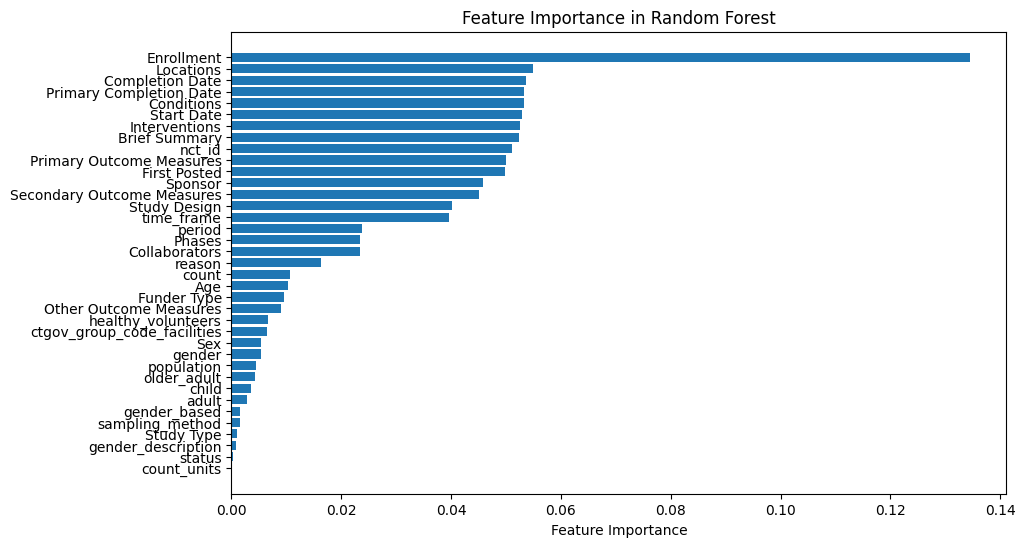

In [ ]:
import matplotlib.pyplot as plt
feature_importances = optimized_model.feature_importances_
sorted_indices = feature_importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align="center")
plt.yticks(range(len(sorted_indices)), X_train.columns[sorted_indices])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forest")
plt.show()

# Saving the Optimized Model

After tuning the hyperparameters and identifying the best-performing Random Forest model, we save it using the `joblib library`. Saving the model ensures that we can reuse it later without needing to retrain, which saves time and computational resources. The optimized model, along with its best hyperparameters, is stored in the file `optimized_random_forest.pkl`. This file can be loaded whenever needed to make predictions or for further evaluations.

In [ ]:
import joblib

# Save the model
joblib.dump(optimized_model, 'optimized_random_forest.pkl')

# Load the model later
loaded_model = joblib.load('optimized_random_forest.pkl')